Now we want to make some model of the data. Let's'

In [1]:
import pandas as pd
import datetime as dt
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.style as style
import numpy as np
import math
import warnings
warnings.filterwarnings('ignore')
import datetime as dt
from statsmodels.tsa.stattools import adfuller
%matplotlib inline

In [2]:
VERBOSE = False

In [3]:
style.use('seaborn-ticks')

In [4]:
cbColors = [ [86,180,233], [230,159,0], [0,114,178], [0,158,115], [240,228,66], [213,94,0], [204,121,167], [0,0,0],]
for rgbList in cbColors:
    rgbList[:] = [x / 255 for x in rgbList]
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=cbColors)

First we want to define our query of the SQL database.

In [5]:
def queryTripsMinMax(dbPath, minRow, maxRow):
	import sqlite3

	db = sqlite3.connect(dbPath)
	cursor = db.cursor()

	cursor.execute('''SELECT startTime, bridgeName, direction, simpleMPH FROM tripsUnique WHERE rowid > ? AND rowid < ?''', (minRow,maxRow))
	result = cursor.fetchall()

	db.close()
	return result

Since we only have around ~22k rows which is not too computationally expensive we can go ahead and get all rows

In [6]:
DB_PATH = 'archives/mydb_Aug13_Final'
rows = queryTripsMinMax(DB_PATH, 1, 23000)

Now we want the time as a datetime object and the MPH as a float so we format these rows and then create a dataframe

In [7]:
formattedRows = [[dt.datetime.fromtimestamp(int(list[0])), list[1], list[2], float(list[3])]  for list in rows]
df = pd.DataFrame(formattedRows, columns=['datetime','highway','direction','simpleMPH'])

We noticed that there are some records that have extrodinarily high MPH. This seems to be caused by the records jumping from one bus to a different bus with the same route and id in a different location, this certainly deserves further exploration. For now we simply remove any records higher than 75MPH.

We sort the records by the time and define date, weekday, and timeofday columns from the datetime object.

In [8]:
df = df.loc[df['simpleMPH'] <= 75]
df = df.sort('datetime')
df['date'] = df['datetime'].apply(lambda x: x.date)
df['weekday'] = df['datetime'].apply(lambda x: x.weekday())
from pandas import date_range, to_datetime
df['timeofdaysec'] = df['datetime'].apply(lambda x: (to_datetime(x) -to_datetime(x.date())).total_seconds())

Now we remove the data that is not representative. Right now we only want to model the traffic for weekdays so we remove all weekend days. And we also remove the dates where the I90 bridge was closed due to the Blue Angles flying overhead.

In [9]:
df = df.loc[(df['datetime'] > dt.datetime(2017, 7, 8))]
df = df.loc[(df['datetime'] < dt.datetime(2017, 8, 3)) | (df['datetime'] > dt.datetime(2017, 8, 6))]
df= df.loc[df['weekday'] < 5]
df = df.set_index('datetime')

We also want to remove any NaN rows

In [10]:
df = df.loc[df.simpleMPH.apply(lambda x: not np.isnan(x))]

Now we separate the dataframe into the data from the different bridges and directions so we don't have to keep selecting them.

In [11]:
df_WI90 = df.loc[(df['highway'] == 'I90') & (df['direction'] == 'W')]
df_EI90 = df.loc[(df['highway'] == 'I90') & (df['direction'] == 'E')]
df_WSR520 = df.loc[(df['highway'] == 'SR520') & (df['direction'] == 'W')]
df_ESR520 = df.loc[(df['highway'] == 'SR520') & (df['direction'] == 'E')]

Now that we have our data we want get a rolling average on a standardized time interval so that we can find the difference between the speed on the two bridges.

Since there are some intervals in which there is no data, if there is no data in the time window we use the previous value in essense assuming that the traffic will be similar to what had it had last been if we don't know what it is now. This will likely introdu is not accurate but we just want to get some idea of what's going on.

We also have to go back and remove the time ranges where the data is not representative, for instance throughout the night we don't want to hold over the values from the last day. We also want to remove weekends and the Blue Angel days.

In [12]:
RANGE_FREQ = '15T'
#RANGE_SEC = 90
TIME_WINDOW = dt.timedelta(minutes=30)
def makeRollingAverage(df):
    if VERBOSE:
        print(df.index.date.min())
        print(df.index.date.max())
        print(df.index.time.min())
        print(df.index.time.max())
    
    myDateRange = pd.date_range(start=dt.datetime(2017,7,10, 5,45,0) , end=dt.datetime(2017,8,11, 23,20,0), freq=RANGE_FREQ)
    if VERBOSE: print(myDateRange)
    a = [0]
    b = [0]
    lastVals=[]
    for datetime in myDateRange:
        vals = df['simpleMPH'].loc[(df.index > datetime) & (df.index < (datetime + TIME_WINDOW))].values
        if len(vals) == 0:
            a.append(a[-1])
            b.append(b[-1])
        elif len(vals) == 1:
            newVals = np.append(lastVals, [vals])
            mean = np.mean(newVals)
            std = np.std(newVals)
            a.append(mean)
            b.append(std)
            
            lastVals = vals
        elif len(vals) > 1:
            mean = vals.mean()
            std = vals.std()
            a.append(mean)
            b.append(std)
            lastVals = vals
    dfa = pd.DataFrame(index=myDateRange, data={'avg':a[1:], 'std':b[1:]})
    dfa['avg'].loc[(dfa.index.time<dt.time(5,45)) | (dfa.index.time>dt.time(23,15))] = 0
    dfa['std'].loc[(dfa.index.time<dt.time(5,45)) | (dfa.index.time>dt.time(23,15))] = 0
    dfa =dfa.reset_index()
    dfa['weekday'] = dfa['index'].apply(lambda x: x.weekday())
    dfa['avg'].loc[dfa['weekday'] > 4] = 0
    dfa['std'].loc[dfa['weekday'] > 4] = 0
    dfa['avg'].loc[(dfa['index'] >= dt.datetime(2017, 8, 2)) & (dfa['index'] < dt.datetime(2017, 8, 6))] = 0
    dfa['std'].loc[(dfa['index'] >= dt.datetime(2017, 8, 2)) & (dfa['index'] < dt.datetime(2017, 8, 6))] = 0
    dfa['avg'].loc[(dfa['index'] >= dt.datetime(2017,8,7, 17,0)) & (dfa['index'] < dt.datetime(2017,8,8, 1,0))] = 0
    dfa['std'].loc[(dfa['index'] >= dt.datetime(2017,8,7, 17,0)) & (dfa['index'] < dt.datetime(2017,8,8, 1,0))] = 0
    dfa=dfa.set_index('index')
    del dfa['weekday']
    return dfa

In [13]:
dfa = makeRollingAverage(df_WI90)
dfb = makeRollingAverage(df_WSR520)
dfc = makeRollingAverage(df_EI90)
dfd = makeRollingAverage(df_ESR520)

Now lets plot these rolling averages compared to the datapoints:

First we plot a week of data, but you can't really see the details

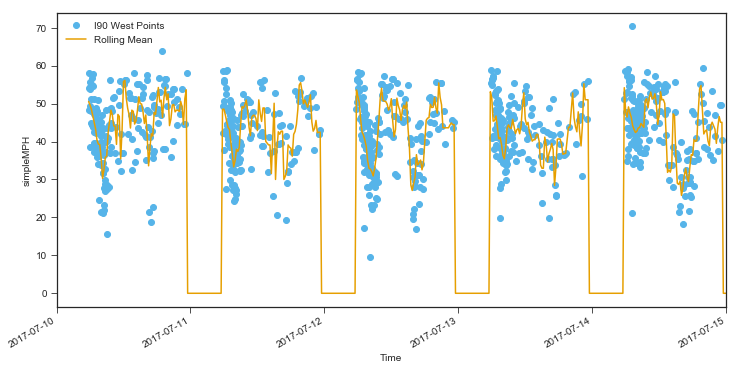

In [127]:
fig, ax = plt.subplots(figsize=(12,6))
kwargs={'lw':0, 'marker':'o'}

df_WI90['simpleMPH'].plot(ax=ax, **kwargs)
dfa.plot(ax=ax, y='avg')
plt.xlabel('Time')
plt.legend(['I90 West Points', 'Rolling Mean'])
plt.ylabel('simpleMPH')

plt.xlim(dt.datetime(2017,7,10),dt.datetime(2017,7,15))
plt.show()

Next we look at one day of data, it looks a bit choppy.

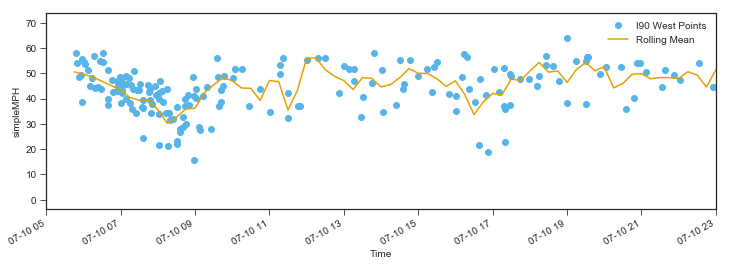

In [126]:
fig, ax = plt.subplots(figsize=(12,4))
kwargs={'lw':0, 'marker':'o'}
df_WI90['simpleMPH'].plot(ax=ax, **kwargs)
dfa.plot(ax=ax, y='avg')
plt.xlabel('Time')
plt.legend(['I90 West Points', 'Rolling Mean'])
plt.ylabel('simpleMPH')
plt.xlim(dt.datetime(2017,7,10,5,0),dt.datetime(2017,7,10,23,0))
plt.show()

When zoomed out it seems a bit choppy, but when zoomed in it looks fairly reasonable.

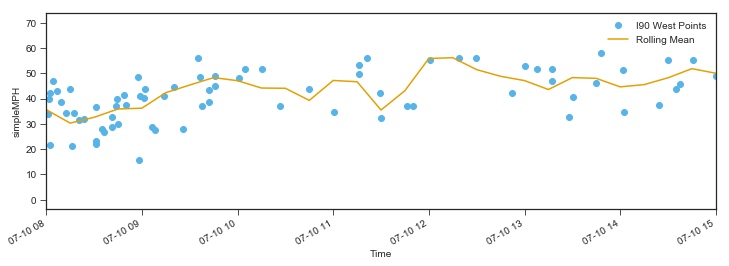

In [125]:
fig, ax = plt.subplots(figsize=(12,4))
df_WI90['simpleMPH'].plot(ax=ax, **kwargs)
dfa.plot(ax=ax,y='avg')
plt.xlim(dt.datetime(2017,7,10,8,0,0),dt.datetime(2017,7,10,15,0,0))
plt.xlabel('Time')
plt.legend(['I90 West Points', 'Rolling Mean'])
plt.ylabel('simpleMPH')
plt.show()

Now we can finally look at the differences between the bridges. We create a new dataframe of the difference between the rolling averages.

In [17]:
avgab = dfa['avg'] - dfb['avg']
avgcd = dfc['avg'] - dfd['avg']

The speed on each bridge should be correlated so the standard deviation shouldn't include the covariance but for now we leave this out for simplicity.

In [18]:
#covab = np.cov(dfa['avg'],dfb['avg']) 
covab = 0
covcd = 0 
#print(covab)
stdab = np.sqrt( dfa['std'] ** 2 + dfb['std'] **2 + 2*covab )
stdcd = np.sqrt( dfc['std'] ** 2 + dfd['std'] **2 + 2*covcd )
#print(stdab)

In [19]:
dfab = pd.DataFrame(index=dfa.index, data={'diff':avgab, 'std':stdab})
dfcd = pd.DataFrame(index=dfc.index, data={'diff':avgcd, 'std':stdcd})

Now let's take a look!

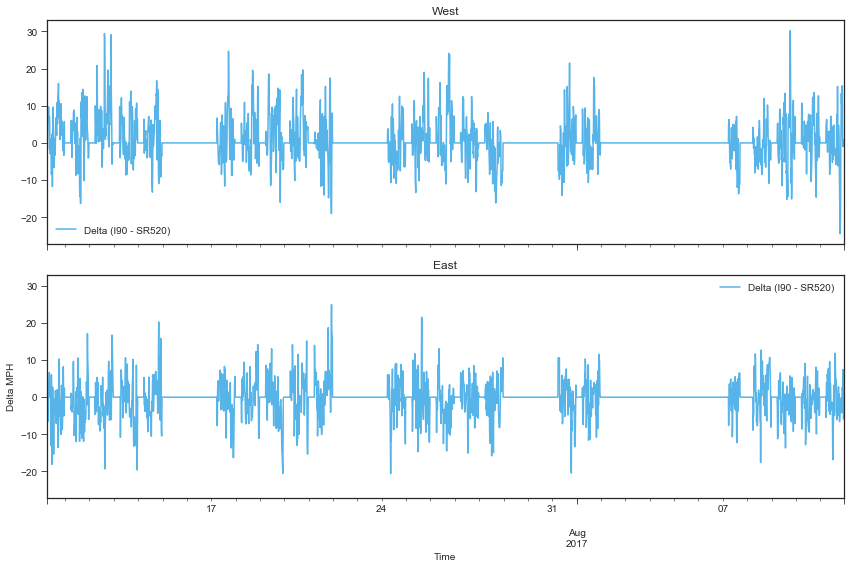

In [87]:
fig, (ax1, ax2) = plt.subplots(nrows=2,ncols=1,figsize=(12,8), sharex=True,sharey=True)

dfab.plot(ax=ax1, y='diff')
ax1.set_title('West')
ax1.legend(['Delta (I90 - SR520)'])

dfcd.plot(ax=ax2, y='diff')
ax2.set_title('East')
ax2.legend(['Delta (I90 - SR520)'])

start = dt.datetime(2017,7,10,6,0)
end = dt.datetime(2017,8,11,23,0)
plt.xlabel('Time')
plt.ylabel('Delta MPH')
plt.xlim(start,end)
plt.tight_layout()
plt.show()

Can't really see much, let's zoom in and plot the original data as well.

In [78]:
def plotDifference(start, end):
    fig, (ax1, ax2) = plt.subplots(nrows=2,ncols=1,figsize=(12,8), sharey=True, sharex=True)

    swgs={'lw':0, 'marker':'o', 'alpha':.3}
    wgs={ 'width':.01,'alpha':.5, 'color':cbColors[2]}
    df_WI90.loc[(df_WI90.index > start) & (df_WI90.index < end)].plot(y='simpleMPH',ax=ax1,**swgs)
    df_WSR520.loc[(df_WSR520.index > start) & (df_WSR520.index < end)].plot(y='simpleMPH',ax=ax1,**swgs)
    dfa[(dfa.index > start) & (dfa.index < end)].plot(ax=ax1, y='avg', lw=3)
    dfb[(dfb.index > start) & (dfb.index < end)].plot(ax=ax1, y='avg', lw=3)
    ax1.bar(dfab[(dfab.index > start) & (dfab.index < end)].index, 
            dfab[(dfab.index > start) & (dfab.index < end)]['diff'].values,
            label='Delta (I90 - SR520)', **wgs) # bottom = dfb[(dfb.index > start) & (dfb.index < end)].avg,
    ax1.set_title('West')
    ax1.legend(['I90 Points','SR520 Points','I90 Rolling Avg','SR520 Rolling Avg','Delta (I90 - SR520)'],
               loc=6,frameon=True)
    
    df_EI90.loc[(df_EI90.index > start) & (df_EI90.index < end)].plot(y='simpleMPH',ax=ax2,**swgs)
    df_ESR520.loc[(df_ESR520.index > start) & (df_ESR520.index < end)].plot(y='simpleMPH',ax=ax2,**swgs)
    dfc[(dfc.index > start) & (dfc.index < end)].plot(ax=ax2, y='avg', lw=3)
    dfd[(dfd.index > start) & (dfd.index < end)].plot(ax=ax2, y='avg', lw=3)
    ax2.bar(dfcd[(dfcd.index > start) & (dfcd.index < end)].index, 
            dfcd[(dfcd.index > start) & (dfcd.index < end)]['diff'].values,
           label='Delta (I90 - SR520)', **wgs) # bottom = dfd[(dfd.index > start) & (dfd.index < end)].avg, 
    ax2.set_title('East')
    ax2.legend(['I90 Points','SR520 Points','I90 Rolling Avg','SR520 Rolling Avg','Delta (I90 - SR520)'],
               loc=6,frameon=True)
    plt.xlabel('Time')
    plt.ylabel('Delta MPH')
    plt.xlim(start,end)
    plt.tight_layout()
    plt.show()

We've defined a function which takes the start and end datetimes and shows the rolling means and the difference, let's look at a few different time ranges and see if it looks right.

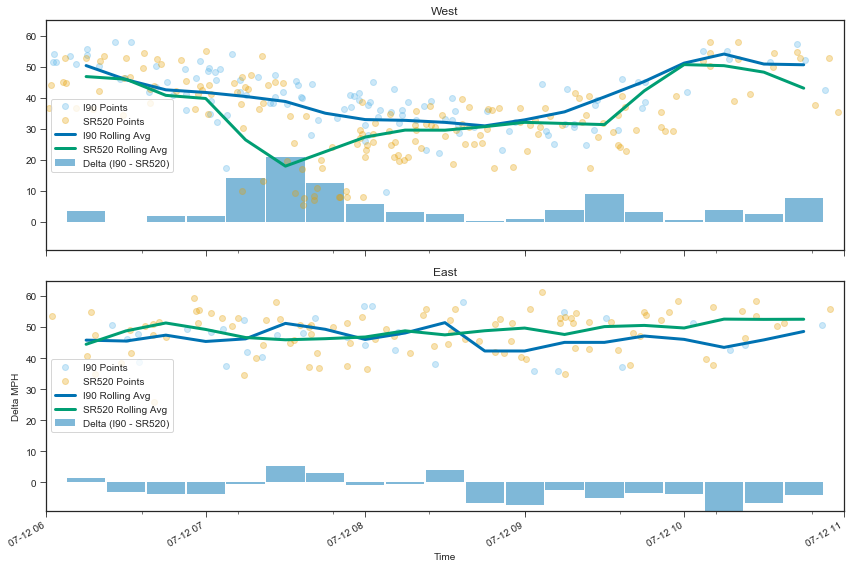

In [79]:
plotDifference(start=dt.datetime(2017,7,12, 6,0), 
               end = dt.datetime(2017,7,12,11,0))

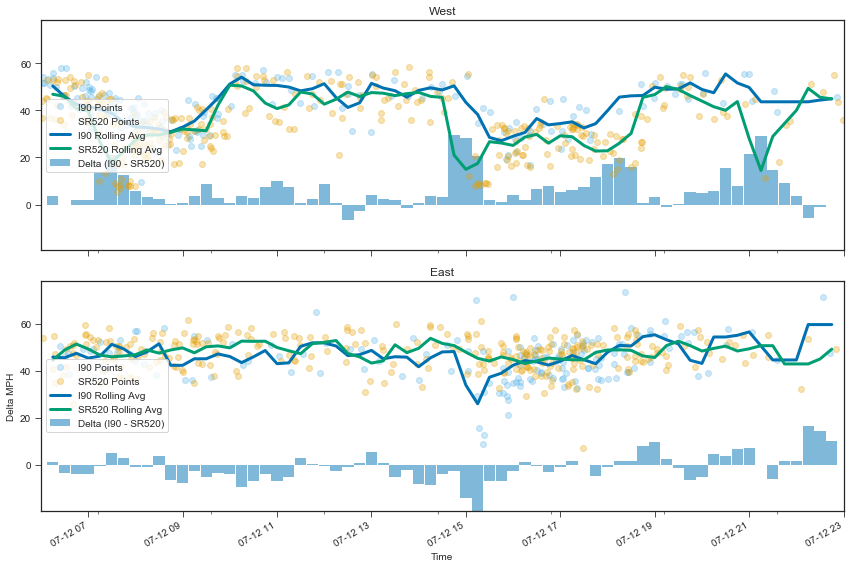

In [80]:
plotDifference(start=dt.datetime(2017,7,12, 6,0), 
               end = dt.datetime(2017,7,12,23,0))

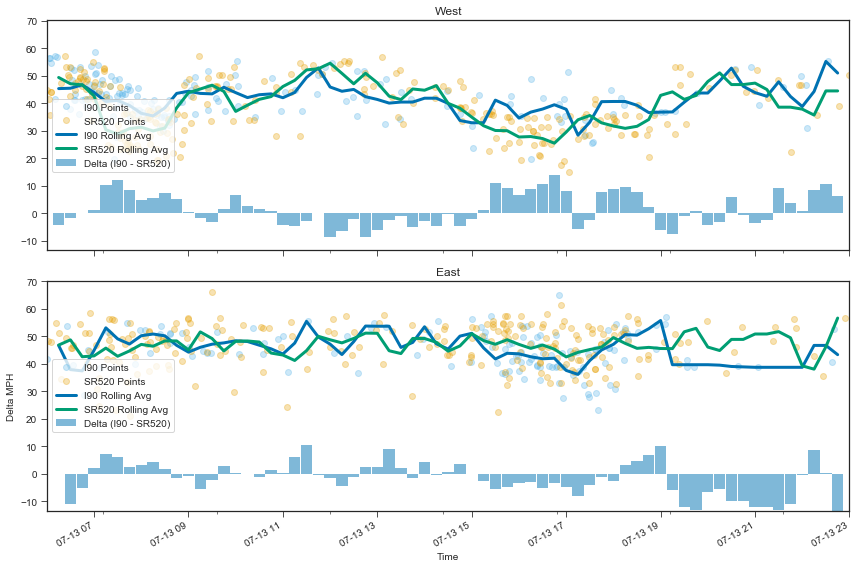

In [81]:
plotDifference(start=dt.datetime(2017,7,13, 6,0), 
               end = dt.datetime(2017,7,13,23,0))

From the plot above we can see that the most negative Delta values were on 7/21 and 8/11, so let's take a look at those days.

While this does look correct, one thing that this model will introduce is extreme values where there are not many data points as in these examples.

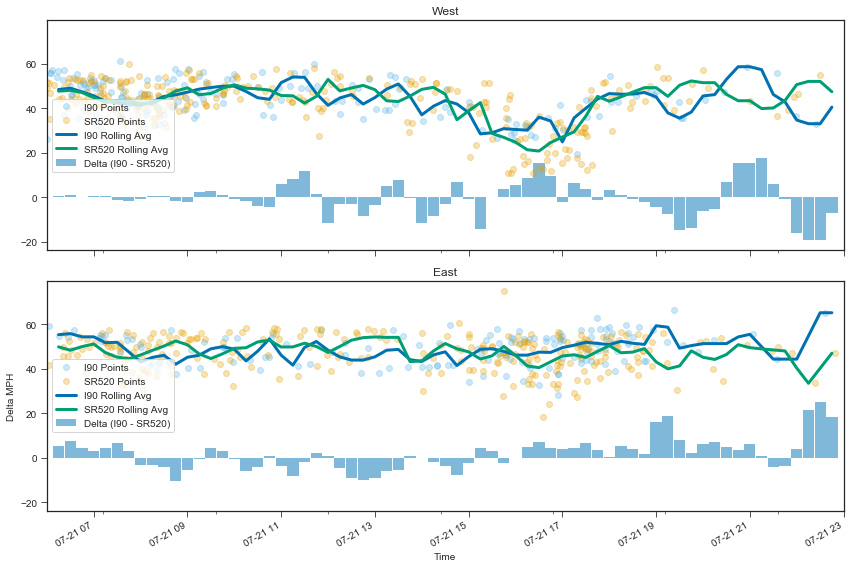

In [91]:
plotDifference(start=dt.datetime(2017,7,21, 6,0), 
               end = dt.datetime(2017,7,21,23,0))

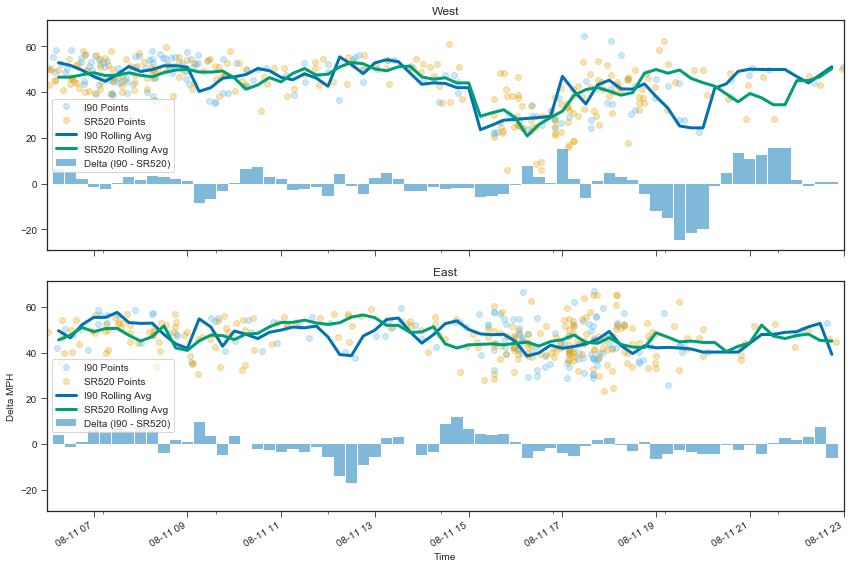

In [92]:
plotDifference(start=dt.datetime(2017,8,11, 6,0), 
               end = dt.datetime(2017,8,11,23,0))

Now let's take all these Delta values and look at them compared to the time of day.
We'll make a new Dataframe for this and use the .time method from the index and then set it to the arbitrary day Jan 1st, 2017 just so we can use the datetime object.

In [73]:
dfab2 = dfab.loc[dfab['diff'] != 0].reset_index()
dfab2['time'] = dfab2['index'].apply(lambda x: dt.datetime.combine(dt.date(2017,1,1), x.time()))
dfab2=dfab2.set_index('time').sort()

dfcd2 = dfcd.loc[dfcd['diff'] != 0].reset_index()
dfcd2['time'] = dfcd2['index'].apply(lambda x: dt.datetime.combine(dt.date(2017,1,1), x.time()))
dfcd2=dfcd2.set_index('time').sort()

Now let's see what we got!

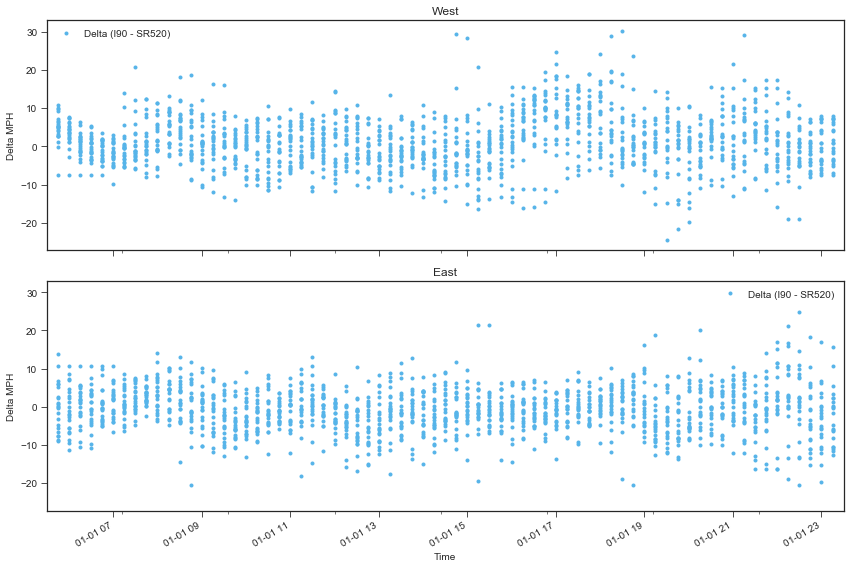

In [44]:
fig, (ax1, ax2) = plt.subplots(nrows=2,ncols=1,figsize=(12,8), sharex=True,sharey=True)
kwargs={'lw':0, 'marker':'.', 'alpha':1}

dfab2.plot(ax=ax1,y='diff',**kwargs)
ax1.set_title('West')
ax1.legend(['Delta (I90 - SR520)'])

dfcd2.plot(ax=ax2,y='diff',**kwargs)
ax2.set_title('East')
ax2.legend(['Delta (I90 - SR520)'])

start = dt.datetime(2017,1,1,5,30)
end = dt.datetime(2017,1,1,23,30)
plt.xlabel('Time')
plt.ylabel('Delta MPH')
ax1.set_ylabel('Delta MPH')
plt.xlim(start,end)
plt.tight_layout()
plt.show()

Now let's make another rolling average of this data. This will give us some idea of which bridge we should usually take at which time.

In [118]:
RANGE_FREQ2 = '30T'
#RANGE_SEC = 90
TIME_WINDOW2 = dt.timedelta(minutes=32)
def makeRollingAverage2(df, win, freq):
    myTimeRange = pd.date_range(start=dt.datetime(2017,1,1, 5,45,0) , end=dt.datetime(2017,1,1, 23,15,0), freq=freq)
    a = [0]
    b = [0]
    lastVals=[]
    for datetime in myTimeRange:
        vals = df['diff'].loc[(df.index > datetime - win) & (df.index < (datetime + win))].values
        if len(vals) == 0:
            a.append(None)
            b.append(None)
        elif len(vals) == 1:
            #newVals = np.append(lastVals, [vals])
            mean = vals
            std = None
            a.append(mean)
            b.append(std)
            
            #lastVals = vals
        elif len(vals) > 1:
            mean = vals.mean()
            std = vals.std()
            a.append(mean)
            b.append(std)
            #lastVals = vals
    dfa = pd.DataFrame(index=myTimeRange, data={'avg':a[1:], 'std':b[1:]})
    return dfa

In [119]:
abpred = makeRollingAverage2(dfab2, TIME_WINDOW2, RANGE_FREQ2)
cdpred = makeRollingAverage2(dfcd2, TIME_WINDOW2, RANGE_FREQ2)
abMean = abpred['avg']
cdMean = cdpred['avg']

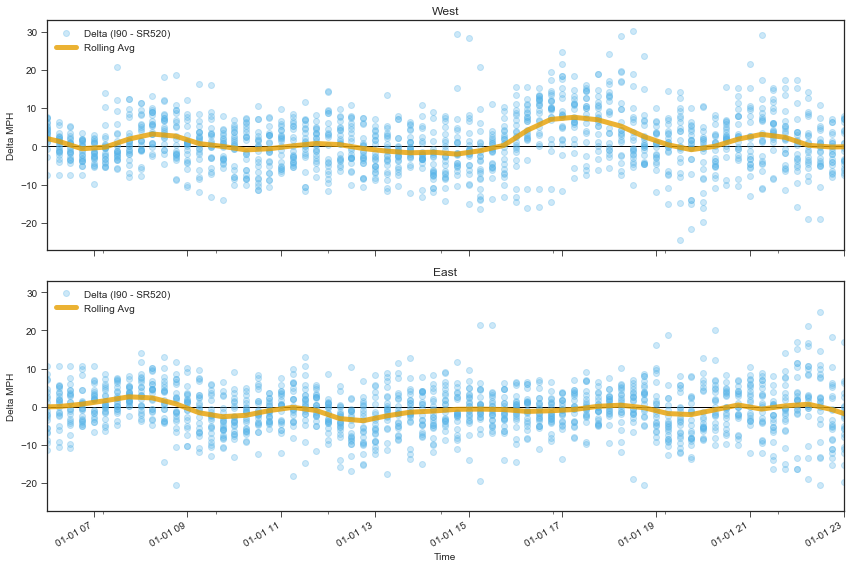

In [117]:
fig, (ax1, ax2) = plt.subplots(nrows=2,ncols=1,figsize=(12,8), sharex=True,sharey=True)
kwargs={'lw':0, 'marker':'o', 'alpha':.3}
kwargs2={'lw':5, 'alpha':.8}
start = dt.datetime(2017,1,1,6,0)
end = dt.datetime(2017,1,1,23,0)

dfab2.plot(ax=ax1,y='diff',**kwargs)
abMean.plot(ax=ax1, **kwargs2)
ax1.legend(['Delta (I90 - SR520)', 'Rolling Avg'])
ax1.plot([start,end],[0,0],'-k',lw=1, alpha=1, zorder=0)
ax1.set_title('West')

dfcd2.plot(ax=ax2,y='diff',**kwargs)
cdMean.plot(ax=ax2, **kwargs2)
ax2.legend(['Delta (I90 - SR520)', 'Rolling Avg'])
ax2.plot([start,end],[0,0],'-k',lw=1, alpha=1, zorder=0)
ax2.set_title('East')

plt.xlabel('Time')
plt.ylabel('Delta MPH')
ax1.set_ylabel('Delta MPH')
plt.xlim(start,end)
plt.tight_layout()
plt.show()

There doesn't seem to be too much of a difference between the bridges most of the time. A 5mph difference over a few miles isn't too big of a dea. The most noticeable difference is the night rush hour going West, which clearly favours the I90 bridge.

This result was very confusing, without any experience one might expect the 520 which is a toll bridge to have less traffic. But this aligns exactly with the experience of friends and family that drive on these bridges frequently. A possible explanation is that they can afford to put a toll on the bridge since it might be better for some people who are going North. And then perhaps if there was no toll there might be even more traffic on the 520.